In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from diabetes_prediction.utils.data import *

# 1. Generate Dataset

In [2]:
data_ids = ['family', 'sample_adult', 'sample_child']

metadatas, datas = {}, {}
for data_id in data_ids:
    metadatas[data_id], datas[data_id] = load_dataset(data_id)

* generate_metadata            | 0.01s (0.00m)
* load_dataset                 | 0.19s (0.00m)
* generate_metadata            | 0.02s (0.00m)
* load_dataset                 | 0.93s (0.02m)
* generate_metadata            | 0.01s (0.00m)
* load_dataset                 | 0.08s (0.00m)


In [3]:
metadata, data = load_merged_datas(metadatas, datas)

* load_merged_datas            | 0.77s (0.01m)


# 2. Preprocessing

In [4]:
dataset = split_dataset(data, drop_unknown=True)

Remove records with unknown label (762 records from 25417 records).
Split dataset into train, validation, test set.
- Train set: 14793
- Validation set: 4931
- Test set: 4931
* split_dataset                | 0.13s (0.00m)


In [5]:
dataset_proc = load_processed_dataset(metadata, dataset, overwrite=True)

* _replace_ambiguous_options   | 1.04s (0.02m)
* _impute_data                 | 0.74s (0.01m)
* _set_dtypes                  | 10.91s (0.18m)
* _impute_numerical_features   | 0.55s (0.01m)
* _drop_columns                | 0.41s (0.01m)
* _manual_handling             | 0.31s (0.01m)
* _drop_diabetes_columns       | 0.08s (0.00m)
* _standardize                 | 0.10s (0.00m)
* _label_encoding              | 0.00s (0.00m)
* fit_transform                | 14.16s (0.24m)
* _replace_ambiguous_options   | 0.57s (0.01m)
* _impute_data                 | 0.53s (0.01m)
* _set_dtypes                  | 0.37s (0.01m)
* _impute_numerical_features   | 0.33s (0.01m)
* _drop_columns                | 0.16s (0.00m)
* _manual_handling             | 0.32s (0.01m)
* _drop_diabetes_columns       | 0.03s (0.00m)
* _standardize                 | 0.03s (0.00m)
* _label_encoding              | 0.00s (0.00m)
* transform                    | 2.36s (0.04m)
* _replace_ambiguous_options   | 0.59s (0.01m)
* _impute_d

# 3. Feature Selection

## 3.1 Numerical Features

### 3.1.1 Correlation Coefficients

In [ ]:
# train_data = dataset_proc['train']

#### 3.1.1.1 Correlation between Features vs Target
Select features with cumulative sum of `|corr(X, y)|` threshold.

In [ ]:
# feature_selector = CorrelationYFeatureSelector(metadata, train_data)
# feature_selector.select(0.3)

#### 3.1.1.2 Correlation between Features
Drop highly correlated features.

In [ ]:
# feature_selector = CorrelationXFeatureSelector(metadata, train_data)
# feature_selector.select(0.8)

### 3.1.2 Multicollinearity
#### 3.1.2.1 Correlation Coefficients
1. Select the biggest correlation pair.
2. Drop the one feature having smaller correlation between target.
3. Iterate until the biggest correlation is smaller than threshold.

In [ ]:
# from sklearn.linear_model import LogisticRegression

# base_estimator = LogisticRegression(random_state=PARAMS.seed)
# corr_xy_feature_selector = CollinearityFeatureSelector(metadata, dataset_proc['train'])
# rst, summary = experiment_numerical_features(metadata, dataset_proc, base_estimator, corr_xy_feature_selector)

#### 3.1.2.2 VIF
1. Detect multicollinearity using **Variance Inflation Factor (VIF)** \
VIF: Measure the strength of correlation between predictor variables
2. Interprete VIF
    - `VIF = 1` : **No correlation** between predictor variable and any other predictor variables.
    - `1 < VIF ≤ 5` : **Moderate correlation** ~.
    - `5 < VIF` : **Severe correlation** ~

In [ ]:
# selected_features = rst[0.6]['features']
# vif_data = get_VIF(dataset_proc['train'][selected_features])

In [ ]:
# plot_correlations(dataset_proc['train'], selected_features, vif_data)

In [ ]:
# selected_features = rst[0.5]['features']
# vif_data = get_VIF(dataset_proc['train'][selected_features])
# plot_VIF(dataset_proc['train'], selected_features, vif_data)

# 4. Modeling

In [103]:
models = {}

## 4.1 Logistic Regression (L1 regularization)

In [104]:
import statsmodels.api as sm

split_Xy = lambda dataset, features: (sm.add_constant(dataset[features], has_constant='add'), dataset[PARAMS.target])

num_features = dataset_proc['train'].select_dtypes('number').drop(columns=PARAMS.target).columns
X_train, y_train = split_Xy(dataset_proc['train'], num_features)
X_val, y_val = split_Xy(dataset_proc['val'],     num_features)
X_test, y_test = split_Xy(dataset_proc['test'],   num_features)

model = sm.Logit(y_train, X_train)
result = model.fit_regularized(method='l1', alpha=1)

summary = pd.concat([result.params, result.params.abs(), result.pvalues], axis='columns', keys=['coef', 'abs(coef)', 'p-value']).sort_values(['p-value', 'abs(coef)'])
summary_significant = summary[summary['p-value'] < 0.05].drop(['const'])
selected_features = summary_significant.index

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2787986400533608
            Iterations: 409
            Function evaluations: 410
            Gradient evaluations: 409


In [105]:
len(selected_features)

33

In [106]:
get_score(y_train, result.predict(X_train))

,accuracy,f1_score,precision,recall,auc
0,0.885,0.287,0.548,0.195,0.587


In [107]:
get_score(y_val, result.predict(X_val))

,accuracy,f1_score,precision,recall,auc
0,0.877,0.244,0.454,0.167,0.57


In [108]:
merge_features_metadata(selected_features, metadata)

,final_id,question_id,description,options,keywords
0,BMI,AHB.200_02.000,body mass index (bmi),"{'9999': 'unknown', '9995': '99.95+', '0001-9994': '00.01-99.94'}","[body mass index, bmi, overweight, obesity, underweight]"
1,AGE_P,HHC.420_00.000,age,"{'85': '85+ years', '01-84': '1-84 years', '00': 'under 1 year', '-1': 'unknown'}",[age]
2,AMDLONGR,AAU.305_00.000,time since last seen/talked to health professional,"{'9': 'don't know', '8': 'not ascertained', '7': 'refused', '5': 'more than 5 years ago', '4': 'more than 2 yrs, but not more than 5 yrs ago', '3': 'more than 1 yr, but not more than 2 yrs ago', '2': 'more than 6 mos, but not more than 1 yr ago', '1': '6 months or less', '0': 'never', '-1': 'unknown'}","[access, source, dr. visit/contact, medical advice, health care provider]"
3,FHSTATEX,FHS.500_00.000,# family members in excellent health,"{'00-25': 'number of family members', '-1': 'unknown'}","[activity limitation, health status]"
4,FHSTATVG,FHS.500_00.000,# family members in very good health,"{'00-25': 'number of family members', '-1': 'unknown'}","[activity limitation, health status]"
5,AHCNOYR2,AAU.280_00.000,"total number of office visits, past 12 m","{'99': 'don't know', '98': 'not ascertained', '97': 'refused', '08': '16 or more', '07': '13-15', '06': '10-12', '05': '8-9', '04': '6-7', '03': '4-5', '02': '2-3', '01': '1', '00': 'none', '-1': 'unknown'}","[access, source, doctor visit, office visit]"
6,FHSTATFR,FHS.500_00.000,# family members in fair health,"{'00-25': 'number of family members', '-1': 'unknown'}","[activity limitation, health status]"
7,ALCSTAT,AHB.170_00.000,alcohol drinking status: recode,"{'10': 'drinking status unknown', '09': 'current drinker, frequency/level unknown', '08': 'current heavier', '07': 'current moderate', '06': 'current light', '05': 'current infrequent', '04': 'former, unknown frequency', '03': 'former regular', '02': 'former infrequent', '01': 'lifetime abstainer', '-1': 'unknown'}","[alcohol, drinking]"
8,RPAP1T1,NAF.160_02.000,time ago date of most recent pap test: time unit,"{'9': 'don't know', '8': 'not ascertained', '7': 'refused', '4': 'year(s) ago', '3': 'month(s) ago', '2': 'week(s) ago', '1': 'day(s) ago', '-1': 'unknown'}",[]
9,SHPNEUNP,AAU.325_00.010,number of pneumonia shots,"{'9': 'don't know', '8': 'not ascertained', '7': 'refused', '6': '6+ times', '1-5': '1-5 times', '-1': 'unknown'}","[access, source, pneumonia, pneumonia shot, pneumonia vaccine]"


[########################################] | 100% Completed | 2.33 ss
* get_VIF                      | 2.50s (0.04m)


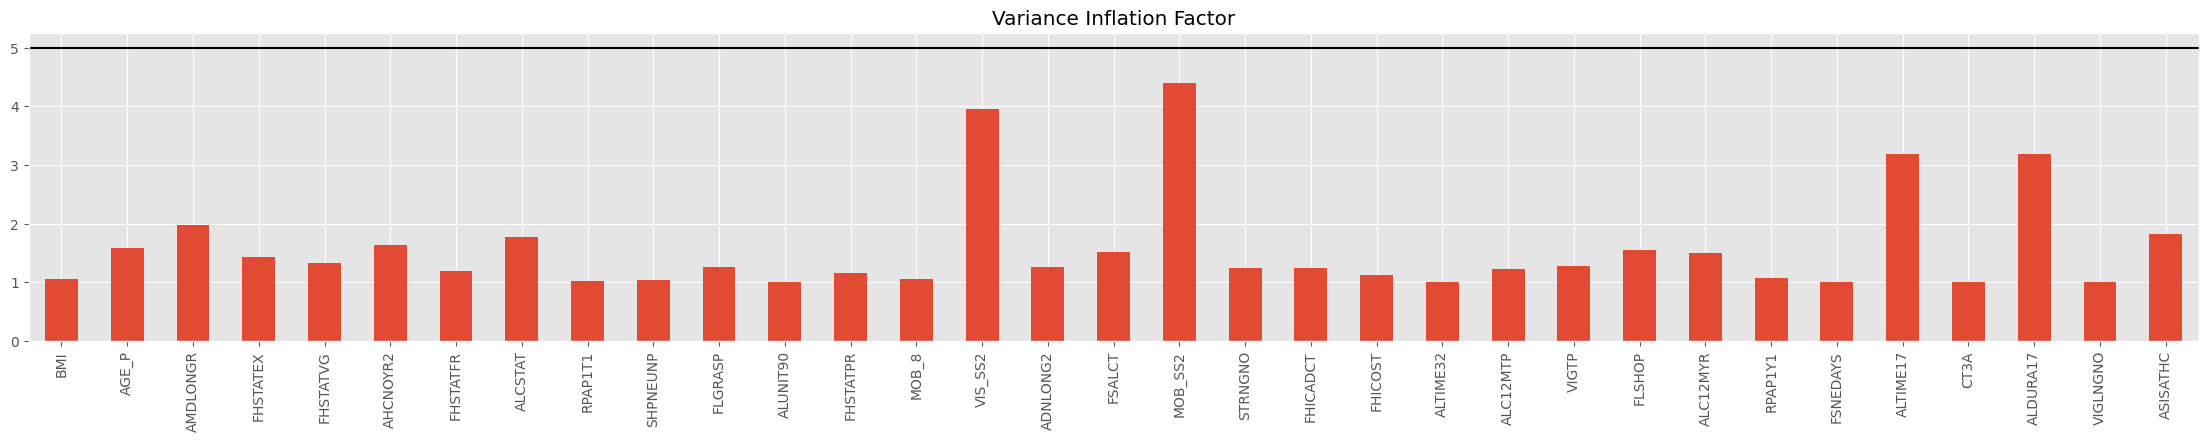

In [109]:
vif_data = get_VIF(dataset_proc['train'][selected_features])
plot_VIF(vif_data)

In [115]:
models['lasso'] = dict(
    dataset=dict(
        X_train=X_train, y_train=y_train,
        X_val=X_val, y_val=y_val,
        X_test=X_test, y_test=y_test
    ),
    model=model,
    result=result,
    scores=dict(
        train=get_score(y_train, result.predict(X_train)),
        val=get_score(y_val, result.predict(X_val)),
    ),
    summary=summary,
    features=num_features,
    selected_features=selected_features,
    vif_data=vif_data
)

## 4.2 ANOVA + Logistic Regression

In [125]:
split_Xy = lambda dataset, features: (dataset[features], dataset[PARAMS.target])

cat_features     = dataset_proc['cat_features']
X_train, y_train = split_Xy(dataset_proc['train'], cat_features)
X_val,   y_val   = split_Xy(dataset_proc['val'],   cat_features)
X_test,  y_test  = split_Xy(dataset_proc['test'],  cat_features)

In [118]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

significant_features = []
for feature in tqdm(cat_features):
    model = ols(f'{PARAMS.target} ~ C({feature})', data=pd.concat([X_train, y_train], axis=1)).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    p_val = anova_table.values[0, 3]
    if p_val < 0.05:
        significant_features.append({
            'feature': feature,
            'anova_table': anova_table
        })

100% 459/459 [00:36<00:00, 12.49it/s]


In [119]:
len(significant_features)

382

In [120]:
significant_features[0]['anova_table']

,sum_sq,df,F,PR(>F)
C(FPX),6.671539,8.0,7.981518,8.609203e-11
Residual,1544.694107,14784.0,NaN,NaN


In [130]:
from sklearn.preprocessing import OneHotEncoder

selected_features = [e['feature'] for e in significant_features]
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
X_train_oh = encoder.fit_transform(X_train[selected_features])
X_val_oh   = encoder.transform(X_val[selected_features])
X_test_oh  = encoder.transform(X_test[selected_features])
cols = encoder.get_feature_names_out()

In [131]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression()
model.fit(X_train_oh, y_train)
p_train = model.predict(X_train_oh)
# print(classification_report(y_train, p_train))
get_score(y_train, p_train)

,accuracy,f1_score,precision,recall,auc
0,0.911,0.517,0.73,0.4,0.69


In [133]:
p_val = model.predict(X_val_oh)
# print(classification_report(y_val, p_val))
get_score(y_val, p_val)

,accuracy,f1_score,precision,recall,auc
0,0.883,0.356,0.514,0.273,0.619


In [144]:
models['logistic_anova'] = dict(
    dataset=dict(
        X_train=pd.DataFrame(X_train_oh, columns=cols), y_train=y_train,
        X_val=pd.DataFrame(X_val_oh, columns=cols), y_val=y_val,
        X_test=pd.DataFrame(X_test_oh, columns=cols), y_test=y_test
    ),
    model=model,
    scores=dict(
        train=get_score(y_train, model.predict(X_train_oh)),
        val=get_score(y_val, model.predict(X_val_oh)),
    ),
    features=cat_features,
    selected_features=selected_features
)

## 4.3 Random Forest

In [164]:
# X_train_num, X_train_cat = models['lasso']['dataset']['X_train'], models['logistic_anova']['dataset']['X_train']
# X_val_num, X_val_cat     = models['lasso']['dataset']['X_val'], models['logistic_anova']['dataset']['X_val']
# X_test_num, X_test_cat   = models['lasso']['dataset']['X_test'], models['logistic_anova']['dataset']['X_test']

# X_train, y_train = pd.concat([X_train_num, X_train_cat], axis=1), models['lasso']['dataset']['y_train']
# X_val, y_val = pd.concat([X_val_num, X_val_cat], axis=1), models['lasso']['dataset']['y_val']
# X_test, y_test = pd.concat([X_test_num, X_test_cat], axis=1), models['lasso']['dataset']['y_test']

In [173]:
split_Xy = lambda dataset: (dataset.drop(columns=PARAMS.target), dataset[PARAMS.target])

X_train, y_train = split_Xy(dataset_proc['train'])
X_val,   y_val   = split_Xy(dataset_proc['val'])
X_test,  y_test  = split_Xy(dataset_proc['test'])

In [180]:
X_train

,FPX,WTIA_SA,WTFA_SA,SEX,HISPAN_I,R_MARITL,MRACRPI2,RACERPI2,MRACBPI2,AGE_P,INTV_MON,REGION,PSTRAT,PPSU,PROX1,PROX2,LATEINTA,PROXYSA,PAR_STAT,DOINGLWA,WHYNOWKA,EVERWRK,SUPERVIS,WRKCATA,BUSINC1A,LOCALL1B,WRKLONGH,HOURPDA,PDSICKA,ONEJOB,WRKLYR4,INDSTRN1,INDSTRN2,OCCUPN1,OCCUPN2,YRSWRKPA,HYPEV,HYPDIFV,HYPMDEV2,HYPMED2,CHLEV,CHLYR,CHLMDEV2,CHLMDNW2,CHDEV,ANGEV,MIEV,HRTEV,STREV,EPHEV,...,FSALYN,FSEINCYN,FSSRRYN,FPENSYN,FOPENSYN,FSSIYN,FTANFYN,FOWBENYN,FINTR1YN,FDIVDYN,FCHSPYN,FINCOTYN,FSSAPLYN,FSDAPLYN,FWICYN,FSALCT,FSEINCCT,FSSRRCT,FPENSCT,FOPENSCT,FSSICT,FTANFCT,FOWBENCT,FINTR1CT,FDIVDCT,FCHSPCT,FINCOTCT,FSSAPLCT,FSDAPLCT,FWICCT,FHIPRVCT,FHISINCT,FHICARCT,FHICADCT,FHICHPCT,FHIMILCT,FHIPUBCT,FHIOGVCT,FHIIHSCT,FHIEXCT,COVCONF,FHICOST,FMEDBILL,FMEDBPAY,FMEDBNOP,FSAF,FHICOVCT,FHICOVYN,FPRCOOH,FHIEBCCT
0,1,-0.899617,-0.923828,2,12,4,1,1,1,1.836991,8,1,-0.970384,1.187482,-1,-1,2,2,3,5,3.0,1.0,1.0,1.0,-1,9.0,-1,2.0,1.0,-1,1.126584,54.0,10.0,63.0,17.0,0.316029,2,-1,-1,-1,2,-1,-1,-1,2,2,2,1,2,2,...,2,2,1,2,1,2,2,2,1,1,2,2,2,2,-1,-1.213562,-0.402578,0.786688,-0.224473,1.789566,-0.210922,-0.099587,-0.099566,0.775580,1.244624,-0.178899,-0.259193,-0.276091,-0.369913,-0.155727,-0.305864,-0.670749,0.73184,-0.374416,-0.088724,-0.263344,-0.079921,-0.055579,-0.067339,-0.183027,-1.184077,0.632350,2,2,-1,2,-0.780277,1,2.0,-0.387459
1,1,0.061800,-0.179029,2,12,1,1,1,1,0.690171,4,4,-1.099903,-0.272812,-1,-1,2,2,3,4,-1,-1,2.0,5.0,2.0,2.0,2.0,2.0,2.0,2.0,-0.769815,8.0,2.0,60.0,17.0,-0.111525,2,-1,-1,-1,2,-1,-1,-1,2,2,2,2,2,2,...,1,1,1,2,1,2,2,2,1,1,2,2,2,2,-1,-0.122109,1.864393,0.786688,-0.224473,1.789566,-0.210922,-0.099587,-0.099566,2.108582,1.244624,-0.178899,-0.259193,-0.276091,-0.369913,-0.155727,-0.305864,0.859186,0.73184,-0.374416,-0.088724,-0.263344,-0.079921,-0.055579,-0.067339,2.258376,0.587368,-0.573808,2,2,-1,2,-0.059268,1,2.0,-1.198393
2,2,0.927860,0.626084,2,12,5,1,1,1,0.362508,11,4,-0.128512,-0.510534,-1,-1,2,2,3,1,-1,-1,1.0,1.0,-1,4.0,1.0,1.0,1.0,2.0,-0.769815,76.0,19.0,63.0,17.0,-0.111525,2,-1,-1,-1,2,-1,-1,-1,2,2,2,2,2,2,...,1,2,2,2,2,2,2,2,2,2,2,2,2,2,-1,0.969344,-0.402578,-0.650392,-0.224473,-0.423715,-0.210922,-0.099587,-0.099566,-0.557423,-0.436351,-0.178899,-0.259193,-0.276091,-0.369913,-0.155727,-0.305864,0.094218,-0.65399,0.665527,-0.088724,-0.263344,-0.079921,-0.055579,-0.067339,-0.183027,-1.184077,-1.176887,2,2,-1,2,-0.059268,1,2.0,-0.387459
3,1,0.221049,-0.214720,2,12,7,1,1,1,0.963223,10,3,-0.322790,0.542236,-1,-1,2,2,3,1,-1,-1,2.0,1.0,-1,1.0,1.0,2.0,2.0,2.0,-0.769815,75.0,19.0,50.0,15.0,1.669949,1,1.0,1.0,1.0,2,-1,-1,-1,2,2,2,2,2,2,...,1,1,1,2,2,2,2,2,2,2,2,2,2,2,-1,-0.122109,1.864393,0.786688,-0.224473,-0.423715,-0.210922,-0.099587,-0.099566,-0.557423,-0.436351,-0.178899,-0.259193,-0.276091,-0.369913,-0.155727,-0.305864,0.094218,0.73184,-0.374416,-0.088724,-0.263344,-0.079921,-0.055579,-0.067339,-0.183027,0.587368,-1.176887,2,2,-1,2,-0.780277,1,2.0,-1.198393
4,1,-0.894705,-0.920232,2,12,4,1,1,1,1.509328,7,4,1.166676,-0.612415,-1,-1,2,2,3,5,3.0,1.0,2.0,1.0,-1,4.0,-1,2.0,9.0,-1,1.126584,58.0,11.0,4.0,1.0,-0.610338,2,-1,-1,-1,2,-1,-1,-1,2,2,2,2,2,2,...,2,2,1,9,1,1,2,2,2,1,2,2,2,2,-1,-1.213562,-0.402578,0.786688,-0.224473,1.789566,3.753712,-0.099587,-0.099566,-0.557423,1.244624,-0.178899,-0.259193,-0.276091,-0.369913,-0.155727,-0.305864,0.094218,0.73184,-0.374416,-0.088724,-0.263344,-0.079921,-0.055579,-0.067339,-0.183027,0.587368,4.250824,2,2,-1,2,-0.780277,1,2.0,-0.387459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14788,2,1.011557,0.311370,2,12,1,1,1,1,1.072444,10,1,0.001007,-0.578455,-1,-1,2,2,3,5,3.0,1.0,1.0,1.0,-1,9.0,-1,1.0,1.0,-1,1.126584,66.0,16.0,83.0,21.0,1.31

In [181]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=PARAMS.seed)
model.fit(X_train, y_train)
p_train = model.predict(X_train)
get_score(y_train, p_train)

,accuracy,f1_score,precision,recall,auc
0,1.0,1.0,1.0,1.0,1.0


In [182]:
p_val = model.predict(X_val)
# print(classification_report(y_val, p_val))
get_score(y_val, p_val)

,accuracy,f1_score,precision,recall,auc
0,0.889,0.204,0.714,0.119,0.556
